## Alignment scores as a function of scoring schemes

https://bioinformatics.stackexchange.com/questions/10594/what-do-the-symbols-mean-in-minimap2s-gap-cost-equation

/scratch/ucgd/lustre-work/quinlan/u6018199/chaisson_2019/analysis/locally_assemble_short_reads/trfermikit/experiments/optimized_for_DELs/minSVSize/data/minSVSize=50/truvari-INS-pacbio-trfermikit


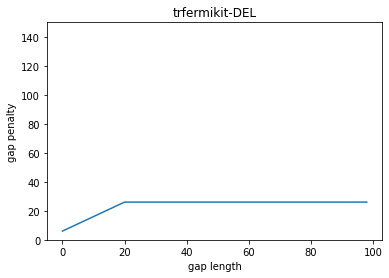

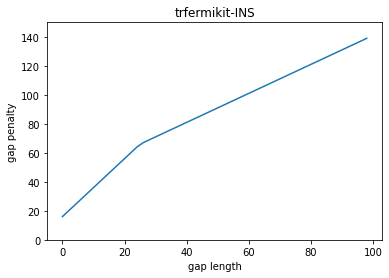

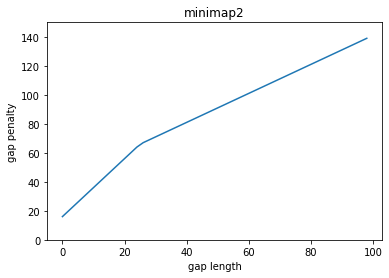

In [1]:
import numpy as np 

def get_alignment_parameters(tool): 
    if tool == 'trfermikit-DEL': 
        return { 
            'singleBaseMatchReward': '10',
            'singleBaseMismatchPenalty': '12',
            'gapOpenPenalties': '6,26',
            'gapExtensionPenalties': '1,0'
        }        
    if tool == 'trfermikit-INS': 
        return { 
            'singleBaseMatchReward': '10',
            'singleBaseMismatchPenalty': '12',
            'gapOpenPenalties': '16,41',
            'gapExtensionPenalties': '2,1'
        }        
    if tool == 'minimap2': 
        # asm10
        return { 
            'singleBaseMatchReward': '1',
            'singleBaseMismatchPenalty': '9',
            'gapOpenPenalties': '16,41',
            'gapExtensionPenalties': '2,1'
        }
    print('not valid tool')
    raise Exception
            
def get_gap_penalty(length, tool):
    gap_open_penalty_1, gap_open_penalty_2 = map(int, get_alignment_parameters(tool)['gapOpenPenalties'].split(','))
    gap_extension_penalty_1, gap_extension_penalty_2 = map(int, get_alignment_parameters(tool)['gapExtensionPenalties'].split(','))
    
    if gap_extension_penalty_1 < gap_extension_penalty_2: raise Exception 
    if gap_open_penalty_1 + gap_extension_penalty_1 > gap_open_penalty_2 + gap_extension_penalty_2: raise Exception 

    return min([
        gap_open_penalty_1 + abs(length)*gap_extension_penalty_1, 
        gap_open_penalty_2 + abs(length)*gap_extension_penalty_2
    ])

def plot_gap_penalty(tool): 
    lengths = np.arange(0, 100, 2)

    gap_penalties = [] 
    for length in lengths: gap_penalties.append(get_gap_penalty(length, tool))

    import matplotlib.pyplot as plt 

    plt.plot(lengths, gap_penalties)
    plt.title(tool)
    plt.xlabel('gap length')
    plt.ylabel('gap penalty')
    plt.ylim(bottom=0)
    plt.ylim(top=150)
    plt.show() 
    
plot_gap_penalty('trfermikit-DEL')
plot_gap_penalty('trfermikit-INS')
plot_gap_penalty('minimap2')

In [2]:
def parse_cigar(cigar): 
    import re
    # \d+ matches any number of digits
    # [] indicates a set of characters
    # {1} specifies that exactly 1 copy of the previous RE should be matched
    # (...) matches whatever regular expression is inside the parentheses, and indicates the start and end of a group
    # r means the string will be treated as raw string
    return re.findall(r'(\d+)([A-Z]{1})', cigar)
    
def get_gap_lengths(cigar):
    gap_lengths = []
    for length, op in parse_cigar(cigar): 
        if op == 'I' or op == 'D': gap_lengths.append(int(length))
    return gap_lengths
            
def get_number_Ms(cigar):
    number_Ms = 0
    for length, op in parse_cigar(cigar): 
        if op == 'M': number_Ms += int(length)
    return number_Ms

def get_match_reward(length, tool): 
    return length*int(get_alignment_parameters(tool)['singleBaseMatchReward'])
    
def get_mismatch_reward(length, tool): 
    return length*int(get_alignment_parameters(tool)['singleBaseMismatchPenalty'])
    
def get_alignment_score(cigar, edit_distance, name, tool):    
    # AS:i:score ... Alignment score generated by aligner
    # NM:i:count ... "Edit Distance" = Number of differences (mismatches plus inserted and deleted bases) between the sequence and reference
    # [https://samtools.github.io/hts-specs/SAMtags.pdf]
    gap_penalty = 0
    number_gapped_basepairs = 0
    for length in get_gap_lengths(cigar): 
        gap_penalty += get_gap_penalty(length, tool)
        number_gapped_basepairs += length        
    number_mismatched_basepairs = edit_distance - number_gapped_basepairs
    number_matched_basepairs = get_number_Ms(cigar) - number_mismatched_basepairs
    alignment_score = ( 
        get_match_reward(number_matched_basepairs, tool) 
        - get_mismatch_reward(number_mismatched_basepairs, tool)
        - gap_penalty
    )
    print('{}; tool = {}; alignment_score = {}'.format(name, tool, alignment_score))

def get_alignment_scores(cigar_DEL, edit_distance_DEL, cigar_INS, edit_distance_INS):
    get_alignment_score(cigar=cigar_DEL, edit_distance=edit_distance_DEL, name='DEL alignment', tool='trfermikit-DEL')
    get_alignment_score(cigar=cigar_INS, edit_distance=edit_distance_INS, name='INS alignment', tool='trfermikit-DEL')    
    print()
    get_alignment_score(cigar=cigar_DEL, edit_distance=edit_distance_DEL, name='DEL alignment', tool='trfermikit-INS')
    get_alignment_score(cigar=cigar_INS, edit_distance=edit_distance_INS, name='INS alignment', tool='trfermikit-INS')    
    print()
    get_alignment_score(cigar=cigar_DEL, edit_distance=edit_distance_DEL, name='DEL alignment', tool='minimap2')
    get_alignment_score(cigar=cigar_INS, edit_distance=edit_distance_INS, name='INS alignment', tool='minimap2')

def locus1():
    comment = 'this locus is really an INS supported by soft-clipping'
    read_name = '288901588:176512244'
    locus = 'chr2:226485667-226486268'

    print(comment)    
    print('Read name: {}'.format(read_name))
    print('Locus: {}'.format(locus))
    print('------------------------')
    
    cigar_DEL = '11M6D5M240D8M1D15M122D251M'
    edit_distance_DEL = 369
    cigar_INS = '251M'
    edit_distance_INS = 0
    get_alignment_scores(cigar_DEL, edit_distance_DEL, cigar_INS, edit_distance_INS)
    
locus1() 

this locus is really an INS supported by soft-clipping
Read name: 288901588:176512244
Locus: chr2:226485667-226486268
------------------------
DEL alignment; tool = trfermikit-DEL; alignment_score = 2829
INS alignment; tool = trfermikit-DEL; alignment_score = 2510

DEL alignment; tool = trfermikit-INS; alignment_score = 2410
INS alignment; tool = trfermikit-INS; alignment_score = 2510

DEL alignment; tool = minimap2; alignment_score = -200
INS alignment; tool = minimap2; alignment_score = 251


In [3]:
def locus2():
    comment = 'truth: INS supported by gapped alignment'
    read_name = '3265768:275673537'
    locus = 'chr1:230588541-230589142'

    print(comment)    
    print('Read name: {}'.format(read_name))
    print('Locus: {}'.format(locus))
    print('------------------------')
    
    cigar_DEL = '8M4D25M100D37M197D428M'
    edit_distance_DEL = 302
    cigar_INS = '11M59I428M'
    edit_distance_INS = 59
    get_alignment_scores(cigar_DEL, edit_distance_DEL, cigar_INS, edit_distance_INS)
    
locus2() 

truth: INS supported by gapped alignment
Read name: 3265768:275673537
Locus: chr1:230588541-230589142
------------------------
DEL alignment; tool = trfermikit-DEL; alignment_score = 4896
INS alignment; tool = trfermikit-DEL; alignment_score = 4364

DEL alignment; tool = trfermikit-INS; alignment_score = 4555
INS alignment; tool = trfermikit-INS; alignment_score = 4290

DEL alignment; tool = minimap2; alignment_score = 85
INS alignment; tool = minimap2; alignment_score = 339


In [4]:
def locus3():
    comment = 'truth: INS supported by soft clipping'
    read_name = '76156255:120068149'
    locus = 'chr5:162906548-162907149'

    print(comment)    
    print('Read name: {}'.format(read_name))
    print('Locus: {}'.format(locus))
    print('------------------------')
    
    cigar_DEL = '7M2I1D1M1D110M30D4M1I6M'
    edit_distance_DEL = 35
    cigar_INS = '7M2I1D1M1D110M'
    edit_distance_INS = 4
    get_alignment_scores(cigar_DEL, edit_distance_DEL, cigar_INS, edit_distance_INS)
    
locus3() 

truth: INS supported by soft clipping
Read name: 76156255:120068149
Locus: chr5:162906548-162907149
------------------------
DEL alignment; tool = trfermikit-DEL; alignment_score = 1225
INS alignment; tool = trfermikit-DEL; alignment_score = 1158

DEL alignment; tool = trfermikit-INS; alignment_score = 1135
INS alignment; tool = trfermikit-INS; alignment_score = 1124

DEL alignment; tool = minimap2; alignment_score = -17
INS alignment; tool = minimap2; alignment_score = 62


In [5]:
def locus4():
    comment = 'truth: STR INS supported by soft clipping'
    read_name = '78759985:179803860'
    locus = 'chr1:216230936-216231537'

    print(comment)    
    print('Read name: {}'.format(read_name))
    print('Locus: {}'.format(locus))
    print('------------------------')
    
    cigar_DEL = '5M8D55M2I121M'
    edit_distance_DEL = 10
    cigar_INS = '55M2I121M'
    edit_distance_INS = 2
    get_alignment_scores(cigar_DEL, edit_distance_DEL, cigar_INS, edit_distance_INS)
    
locus4() 

truth: STR INS supported by soft clipping
Read name: 78759985:179803860
Locus: chr1:216230936-216231537
------------------------
DEL alignment; tool = trfermikit-DEL; alignment_score = 1788
INS alignment; tool = trfermikit-DEL; alignment_score = 1752

DEL alignment; tool = trfermikit-INS; alignment_score = 1758
INS alignment; tool = trfermikit-INS; alignment_score = 1740

DEL alignment; tool = minimap2; alignment_score = 129
INS alignment; tool = minimap2; alignment_score = 156


In [6]:
def locus5():
    comment = 'truth: INS supported by soft clipping'
    read_name = '193515671:86010582'
    locus = 'chr15:69285718-69286319'

    print(comment)    
    print('Read name: {}'.format(read_name))
    print('Locus: {}'.format(locus))
    print('------------------------')
    
    cigar_DEL = '125M9D1M2D2M'
    edit_distance_DEL = 11
    cigar_INS = '125M'
    edit_distance_INS = 0
    get_alignment_scores(cigar_DEL, edit_distance_DEL, cigar_INS, edit_distance_INS)
    
locus5() 

truth: INS supported by soft clipping
Read name: 193515671:86010582
Locus: chr15:69285718-69286319
------------------------
DEL alignment; tool = trfermikit-DEL; alignment_score = 1257
INS alignment; tool = trfermikit-DEL; alignment_score = 1250

DEL alignment; tool = trfermikit-INS; alignment_score = 1226
INS alignment; tool = trfermikit-INS; alignment_score = 1250

DEL alignment; tool = minimap2; alignment_score = 74
INS alignment; tool = minimap2; alignment_score = 125


In [7]:
def locus6():
    comment = 'truth: INS supported by soft clipping'
    read_name = '220370081:219792508'
    locus = 'chr4:3293666-3294267'

    print(comment)    
    print('Read name: {}'.format(read_name))
    print('Locus: {}'.format(locus))
    print('------------------------')
    
    cigar_DEL = '19M181D3M1D317M'
    edit_distance_DEL = 184
    cigar_INS = '309M'
    edit_distance_INS = 1
    get_alignment_scores(cigar_DEL, edit_distance_DEL, cigar_INS, edit_distance_INS)
    
locus6() 

truth: INS supported by soft clipping
Read name: 220370081:219792508
Locus: chr4:3293666-3294267
------------------------
DEL alignment; tool = trfermikit-DEL; alignment_score = 3313
INS alignment; tool = trfermikit-DEL; alignment_score = 3068

DEL alignment; tool = trfermikit-INS; alignment_score = 3106
INS alignment; tool = trfermikit-INS; alignment_score = 3068

DEL alignment; tool = minimap2; alignment_score = 79
INS alignment; tool = minimap2; alignment_score = 299


In [8]:
def locus7():
    comment = 'truth: INS supported by soft clipping'
    read_name = '209718933:245295857'
    locus = 'chr9:125984867-125985468'

    print(comment)    
    print('Read name: {}'.format(read_name))
    print('Locus: {}'.format(locus))
    print('------------------------')
    
    cigar_DEL = '3M3D6M62D5M1D4M2D2M1D1M8D6M6D247M'
    edit_distance_DEL = 84
    cigar_INS = '247M'
    edit_distance_INS = 1
    get_alignment_scores(cigar_DEL, edit_distance_DEL, cigar_INS, edit_distance_INS)
    
locus7() 

truth: INS supported by soft clipping
Read name: 209718933:245295857
Locus: chr9:125984867-125985468
------------------------
DEL alignment; tool = trfermikit-DEL; alignment_score = 2635
INS alignment; tool = trfermikit-DEL; alignment_score = 2448

DEL alignment; tool = trfermikit-INS; alignment_score = 2477
INS alignment; tool = trfermikit-INS; alignment_score = 2448

DEL alignment; tool = minimap2; alignment_score = 23
INS alignment; tool = minimap2; alignment_score = 237


In [9]:
def locus8():
    comment = 'truth: INS/DUP supported by soft clipping'
    read_name = '121923856:115332571'
    locus = 'chr16:69918894-69919495'
    
    print(comment)    
    print('Read name: {}'.format(read_name))
    print('Locus: {}'.format(locus))
    print('------------------------')
    
    cigar_DEL = '2M1D2M5D5M208D3M1D1M6D250M'
    edit_distance_DEL = 224
    cigar_INS = '250M'
    edit_distance_INS = 2
    get_alignment_scores(cigar_DEL, edit_distance_DEL, cigar_INS, edit_distance_INS)
    
locus8() 

truth: INS/DUP supported by soft clipping
Read name: 121923856:115332571
Locus: chr16:69918894-69919495
------------------------
DEL alignment; tool = trfermikit-DEL; alignment_score = 2501
INS alignment; tool = trfermikit-DEL; alignment_score = 2456

DEL alignment; tool = trfermikit-INS; alignment_score = 2225
INS alignment; tool = trfermikit-INS; alignment_score = 2456

DEL alignment; tool = minimap2; alignment_score = -106
INS alignment; tool = minimap2; alignment_score = 230


## Tracebacks as a function of alignment parameters and query length

********************
tool = minimap2
********************
GCGACCGGAGAAGTATATTGCGCAAGAATATTGCGCAAGTATATTGCGCACCGAGGAGG
                       ||||||||||||||||||||||||||||||||||||
             GCGACCGGAGAAGAATATTGCGCAAGTATATTGCGCACCGAGGAGG

GCGACCGGAGAAGTATATTGCGCAAGAATATTGCGCAAGTATATTGCGC          
                       ||||||||||||||||||||||||||          
             GCGACCGGAGAAGAATATTGCGCAAGTATATTGCGCACCGAGGAGG

GCGACCGGAGAAGTATATTGCGCAAGAATATTGCGCAAG       
|||||||||||||.||||||||||||.||||||||||         
GCGACCGGAGAAGAATATTGCGCAAGTATATTGCGCACCGAGGAGG

GCGACCGGAGAAGTATATTGCGCAAGAAT                 
|||||||||||||.||||||||||||                    
GCGACCGGAGAAGAATATTGCGCAAGTATATTGCGCACCGAGGAGG

GCGACCGGAGAAGTATATT                           
|||||||||||||                                 
GCGACCGGAGAAGAATATTGCGCAAGTATATTGCGCACCGAGGAGG

GCGACCGGA                                     
|||||||||                                     
GCGACCGGAGAAGAATATTGCGCAAGTATATTGCGCACCGAGGAGG



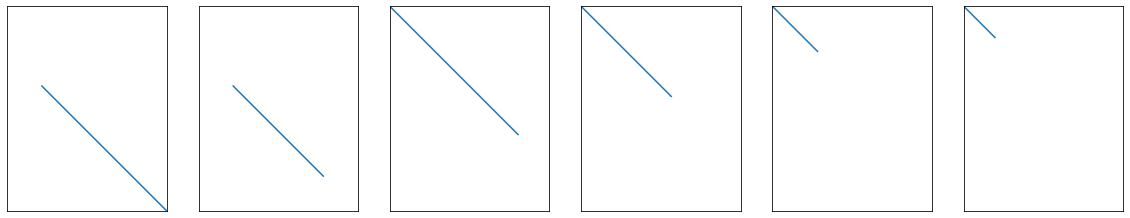

             GCGACCGGAGAAGAATATTGCGCAAGTATATTGCGCACCGAGGAGG
                       ||||||||||||||||||||||||||||||||||||
GCGACCGGAGAAGTATATTGCGCAAGAATATTGCGCAAGTATATTGCGCACCGAGGAGG

             GCGACCGGAGAAGAATATTGCGCAAGTATATTGCGC          
                       ||||||||||||||||||||||||||          
GCGACCGGAGAAGTATATTGCGCAAGAATATTGCGCAAGTATATTGCGCACCGAGGAGG

GCGACCGGAGAAGAATATTGCGCAAG                                 
|||||||||||||.||||||||||||                                 
GCGACCGGAGAAGTATATTGCGCAAGAATATTGCGCAAGTATATTGCGCACCGAGGAGG

GCGACCGGAGAAGAAT                                           
|||||||||||||                                              
GCGACCGGAGAAGTATATTGCGCAAGAATATTGCGCAAGTATATTGCGCACCGAGGAGG

GCGACC                                                     
||||||                                                     
GCGACCGGAGAAGTATATTGCGCAAGAATATTGCGCAAGTATATTGCGCACCGAGGAGG



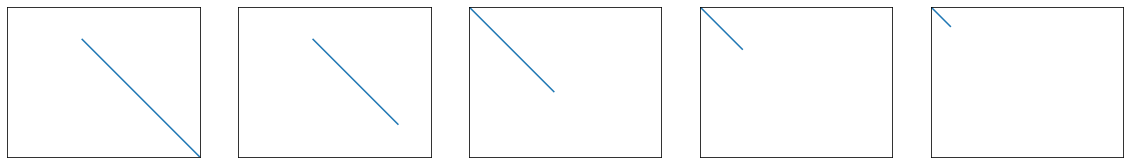

********************
tool = trfermikit-INS
********************
GCGACCGGAGAAGTATATTGCGCAAGAATATTGCGCAAGTATATTGCGCACCGAGGAGG
||||||||||-------------||||||||||||||||||||||||||||||||||||
GCGACCGGAG-------------AAGAATATTGCGCAAGTATATTGCGCACCGAGGAGG

GCGACCGGAGAAGTATATTGCGCAAGAATATTGCGCAAGTATATTGCGC
|||||||||||||.||||||||||||.||||||||||            
GCGACCGGAGAAGAATATTGCGCAAGTATATTGCGCACCGAGGAGG   

GCGACCGGAGAAGTATATTGCGCAAGAATATTGCGCAAG       
|||||||||||||.||||||||||||.||||||||||         
GCGACCGGAGAAGAATATTGCGCAAGTATATTGCGCACCGAGGAGG

GCGACCGGAGAAGTATATTGCGCAAGAAT                 
|||||||||||||.||||||||||||.||                 
GCGACCGGAGAAGAATATTGCGCAAGTATATTGCGCACCGAGGAGG

GCGACCGGAGAAGTATATT                           
|||||||||||||.|||||                           
GCGACCGGAGAAGAATATTGCGCAAGTATATTGCGCACCGAGGAGG

GCGACCGGA                                     
|||||||||                                     
GCGACCGGAGAAGAATATTGCGCAAGTATATTGCGCACCGAGGAGG



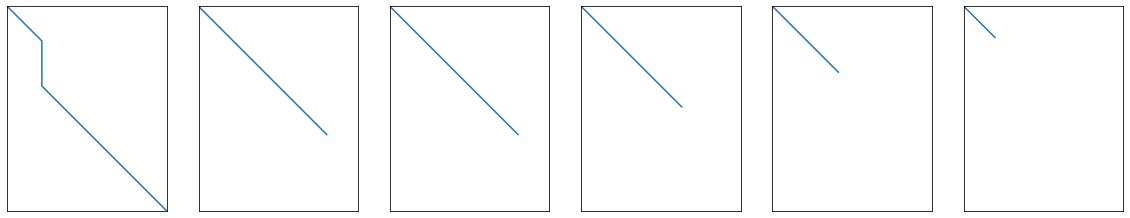

GCGACCGGAG-------------AAGAATATTGCGCAAGTATATTGCGCACCGAGGAGG
||||||||||-------------||||||||||||||||||||||||||||||||||||
GCGACCGGAGAAGTATATTGCGCAAGAATATTGCGCAAGTATATTGCGCACCGAGGAGG

GCGACCGGAG-------------AAGAATATTGCGCAAGTATATTGCGC          
||||||||||-------------||||||||||||||||||||||||||          
GCGACCGGAGAAGTATATTGCGCAAGAATATTGCGCAAGTATATTGCGCACCGAGGAGG

GCGACCGGAGAAGAATATTGCGCAAG                                 
|||||||||||||.||||||||||||                                 
GCGACCGGAGAAGTATATTGCGCAAGAATATTGCGCAAGTATATTGCGCACCGAGGAGG

GCGACCGGAGAAGAAT                                           
|||||||||||||.||                                           
GCGACCGGAGAAGTATATTGCGCAAGAATATTGCGCAAGTATATTGCGCACCGAGGAGG

GCGACC                                                     
||||||                                                     
GCGACCGGAGAAGTATATTGCGCAAGAATATTGCGCAAGTATATTGCGCACCGAGGAGG



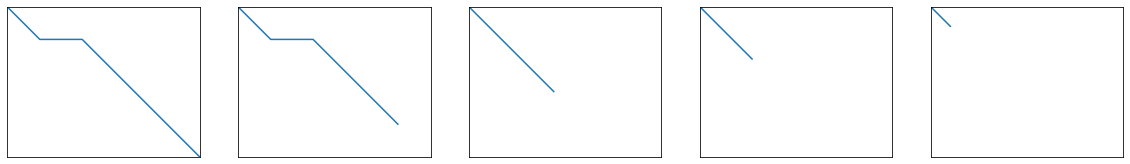

********************
tool = trfermikit-DEL
********************
GCGACCGGAGAAGTATATTGCGCAAGAATATTGCGCAAGTATATTGCGCACCGAGGAGG
||||||||||-------------||||||||||||||||||||||||||||||||||||
GCGACCGGAG-------------AAGAATATTGCGCAAGTATATTGCGCACCGAGGAGG

GCGACCGGAGAAGTATATTGCGCAAGAATATTGCGCAAGTATATTGCGC          
||||||||||-------------||||||||||||||||||||||||||          
GCGACCGGAG-------------AAGAATATTGCGCAAGTATATTGCGCACCGAGGAGG

GCGACCGGAGAAGTATATTGCGCAAGAATATTGCGCA---AG    
|||||||||||||.||||||||||||.||||||||||---||    
GCGACCGGAGAAGAATATTGCGCAAGTATATTGCGCACCGAGGAGG

GCGACCGGAGAAGTATATTGCGCAAG-A-AT               
|||||||||||||.||||||||||||-|-||               
GCGACCGGAGAAGAATATTGCGCAAGTATATTGCGCACCGAGGAGG

GCGACCGGAG-------------AAGTATATT              
||||||||||-------------|||||||||              
GCGACCGGAGAAGAATATTGCGCAAGTATATTGCGCACCGAGGAGG

GCGACCGGA                                     
|||||||||                                     
GCGACCGGAGAAGAATATTGCGCAAGTATATTGCGCACCGAGGAGG



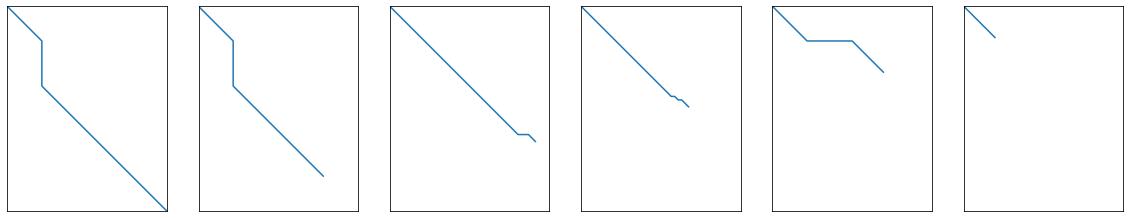

GCGACCGGAG-------------AAGAATATTGCGCAAGTATATTGCGCACCGAGGAGG
||||||||||-------------||||||||||||||||||||||||||||||||||||
GCGACCGGAGAAGTATATTGCGCAAGAATATTGCGCAAGTATATTGCGCACCGAGGAGG

GCGACCGGAG-------------AAGAATATTGCGCAAGTATATTGCGC          
||||||||||-------------||||||||||||||||||||||||||          
GCGACCGGAGAAGTATATTGCGCAAGAATATTGCGCAAGTATATTGCGCACCGAGGAGG

GCGACCGGAG-------------AAGAATATTGCGCAAG                    
||||||||||-------------||||||||||||||||                    
GCGACCGGAGAAGTATATTGCGCAAGAATATTGCGCAAGTATATTGCGCACCGAGGAGG

GCGACCGGAGAAG-A-AT                                         
|||||||||||||-|-||                                         
GCGACCGGAGAAGTATATTGCGCAAGAATATTGCGCAAGTATATTGCGCACCGAGGAGG

GCGACC                                                     
||||||                                                     
GCGACCGGAGAAGTATATTGCGCAAGAATATTGCGCAAGTATATTGCGCACCGAGGAGG



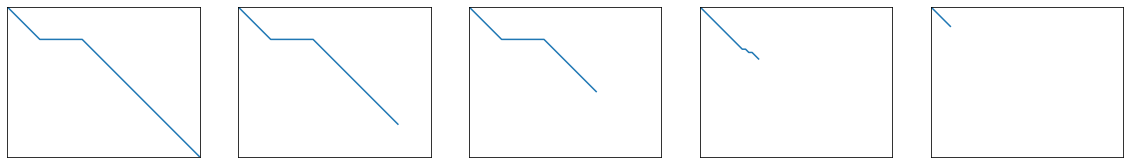

In [12]:
# http://biopython.org/DIST/docs/tutorial/Tutorial.html#sec98
from Bio import Align
import numpy as np
import matplotlib.pyplot as plt

def get_gap_penalty_biopython(tool):
    return lambda start, length: -get_gap_penalty(length, tool)

def compute_alignment(query, reference, aligner):
    alignments = aligner.align(query, reference)
    # biopython docs: "The alignment score [...] has the same value for each alignment in alignments"
    if len(alignments) > 1: 
        pass
#         print('{} alignments for query: {}'.format(len(alignments), query))    
#         raise 
    return alignments[0]
    
def plot_tracebacks(query, reference, tool, sub_query_step_size=1):
    aligner = Align.PairwiseAligner(
        match_score = int(get_alignment_parameters(tool)['singleBaseMatchReward']), 
        mismatch_score = -int(get_alignment_parameters(tool)['singleBaseMismatchPenalty']), 
        gap_score = get_gap_penalty_biopython(tool),
        mode = 'local')
#     print()
#     print(aligner)
#     print(aligner.algorithm)
#     print()
    
    sub_query_lengths = np.arange(len(query), 2, -sub_query_step_size)
    number_tracebacks = len(sub_query_lengths)
    grid = (1, number_tracebacks)
    plt.subplots(*grid, figsize=(20,20))
    for index, sub_query_length in enumerate(sub_query_lengths):
        alignment = compute_alignment(query[:sub_query_length], reference, aligner) 
        rows, columns = zip(*alignment.path)

        print(alignment)
        
        plt.subplot(*grid, index + 1)
        plt.plot(columns, rows)
        
        number_rows = len(query)       
        number_columns = len(reference)
        plt.gca().axis([0, number_columns, number_rows, 0])
        plt.gca().set_aspect('equal', 'box')
        plt.gca().xaxis.set_ticks_position('top')
        plt.gca().set_xticks(np.arange(number_columns + 1))
        plt.gca().set_yticks(np.arange(number_rows + 1))
        plt.gca().set_xticklabels([''] + list(reference))
        plt.gca().set_yticklabels([''] + list(query))

        plt.tick_params(
            axis='x',          
            which='both',      # both major and minor ticks are affected
            top=False,         # ticks are off
            labeltop=False)    # labels are off
        plt.tick_params(
            axis='y',          
            which='both',      
            left=False,        
            labelleft=False)   
#         plt.axis('off')

        start_of_first_block_in_query = alignment.aligned[0][0][0]
        end_of_last_block_in_query = alignment.aligned[0][-1][1]
        # https://en.wikipedia.org/wiki/Monospaced_font :
#         plt.title('{}\nscore = {}\n'.format(str(alignment), alignment.score), font='monospace')  
    plt.show()

def generate_random_sequence(length):
    return ''.join(np.random.choice(['A', 'C', 'G', 'T'], size=length, p=0.25*np.ones(4)))

def mutate_sequence(sequence):
    import copy
    sequence_prime = copy.deepcopy(sequence)
    sequence_prime = list(sequence_prime) 
    sequence_prime[np.random.randint(0, len(sequence_prime))] \
        = np.random.choice(['A', 'C', 'G', 'T'], p=0.25*np.ones(4))
    return ''.join(sequence_prime)
 
X = generate_random_sequence(10)
# print('X = {}'.format(X))
A = generate_random_sequence(5)
Aprime = mutate_sequence(A)
B = generate_random_sequence(8)
Y = generate_random_sequence(10)
# print('Y = {}'.format(Y))

def plot_two_tracebacks(short_sequence, long_sequence, tool):
    print('********************')
    print('tool = {}'.format(tool))
    print('********************')
    plot_tracebacks(long_sequence, short_sequence, tool, sub_query_step_size=10) 
    plot_tracebacks(short_sequence, long_sequence, tool, sub_query_step_size=10) 
    
def plot_six_tracebacks(short_sequence, long_sequence): 
    plot_two_tracebacks(short_sequence, long_sequence, 'minimap2')
    plot_two_tracebacks(short_sequence, long_sequence, 'trfermikit-INS')
    plot_two_tracebacks(short_sequence, long_sequence, 'trfermikit-DEL')
    
plot_six_tracebacks(
    short_sequence = X + A + B + Aprime + B + Y,
    long_sequence = X + Aprime + B + A + B + Aprime + B + Y)

********************
tool = minimap2
********************
GCGACCGGAGAAGAATATTGCGCAAGAAACCGAGGAGGTATTGCGC
               |||||||||||||||||||||||||||||||
     GCGACCGGAGTATTGCGCAAGAAACCGAGGAGGTATTGCGC

GCGACCGGAGAAGAATATTGCGCAAGAAACCGAGGA          
               |||||||||||||||||||||          
     GCGACCGGAGTATTGCGCAAGAAACCGAGGAGGTATTGCGC

GCGACCGGAGAAGAATATTGCGCAAG                    
               |||||||||||                    
     GCGACCGGAGTATTGCGCAAGAAACCGAGGAGGTATTGCGC

GCGACCGGAGAAGAAT                         
||||||||||                               
GCGACCGGAGTATTGCGCAAGAAACCGAGGAGGTATTGCGC

GCGACC                                   
||||||                                   
GCGACCGGAGTATTGCGCAAGAAACCGAGGAGGTATTGCGC



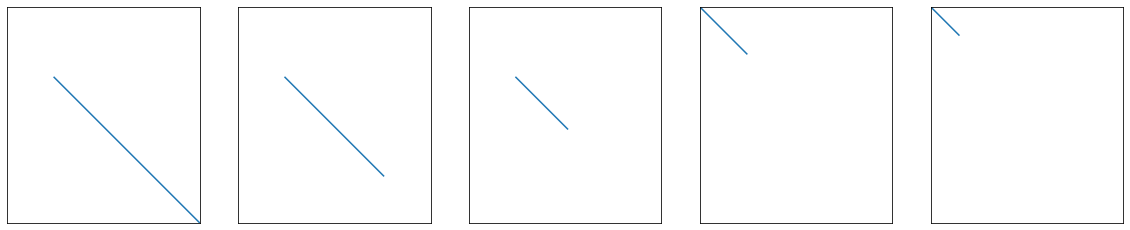

     GCGACCGGAGTATTGCGCAAGAAACCGAGGAGGTATTGCGC
               |||||||||||||||||||||||||||||||
GCGACCGGAGAAGAATATTGCGCAAGAAACCGAGGAGGTATTGCGC

     GCGACCGGAGTATTGCGCAAGAAACCGAGGA          
               |||||||||||||||||||||          
GCGACCGGAGAAGAATATTGCGCAAGAAACCGAGGAGGTATTGCGC

     GCGACCGGAGTATTGCGCAAG                    
               |||||||||||                    
GCGACCGGAGAAGAATATTGCGCAAGAAACCGAGGAGGTATTGCGC

GCGACCGGAGT                                   
||||||||||                                    
GCGACCGGAGAAGAATATTGCGCAAGAAACCGAGGAGGTATTGCGC



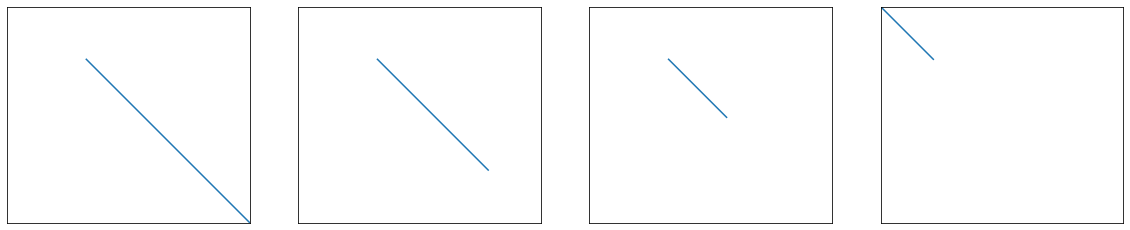

********************
tool = trfermikit-INS
********************
GCGACCGGAGAAGAATATTGCGCAAGAAACCGAGGAGGTATTGCGC
||||||||||-----|||||||||||||||||||||||||||||||
GCGACCGGAG-----TATTGCGCAAGAAACCGAGGAGGTATTGCGC

GCGACCGGAGAAGAATATTGCGCAAGAAACCGAGGA          
||||||||||-----|||||||||||||||||||||          
GCGACCGGAG-----TATTGCGCAAGAAACCGAGGAGGTATTGCGC

GCGACCGGAGAAGAATATTGCGCAAG                    
||||||||||-----|||||||||||                    
GCGACCGGAG-----TATTGCGCAAGAAACCGAGGAGGTATTGCGC

GCGACCGGAG--------AAGAAT                 
||||||||||--------|||||                  
GCGACCGGAGTATTGCGCAAGAAACCGAGGAGGTATTGCGC

GCGACC                                   
||||||                                   
GCGACCGGAGTATTGCGCAAGAAACCGAGGAGGTATTGCGC



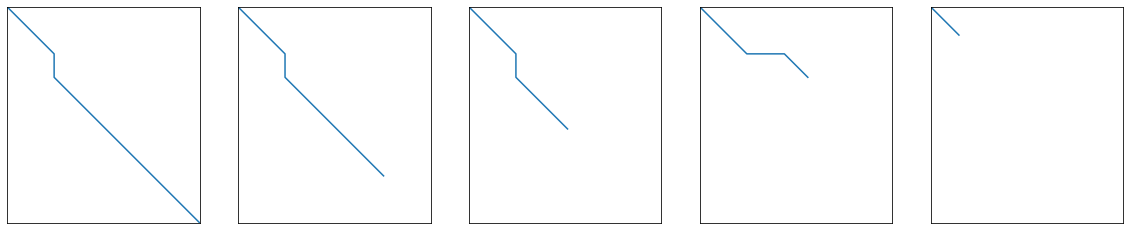

GCGACCGGAG-----TATTGCGCAAGAAACCGAGGAGGTATTGCGC
||||||||||-----|||||||||||||||||||||||||||||||
GCGACCGGAGAAGAATATTGCGCAAGAAACCGAGGAGGTATTGCGC

GCGACCGGAG-----TATTGCGCAAGAAACCGAGGA          
||||||||||-----|||||||||||||||||||||          
GCGACCGGAGAAGAATATTGCGCAAGAAACCGAGGAGGTATTGCGC

GCGACCGGAG-----TATTGCGCAAG                    
||||||||||-----|||||||||||                    
GCGACCGGAGAAGAATATTGCGCAAGAAACCGAGGAGGTATTGCGC

GCGACCGGAGT                                   
||||||||||                                    
GCGACCGGAGAAGAATATTGCGCAAGAAACCGAGGAGGTATTGCGC



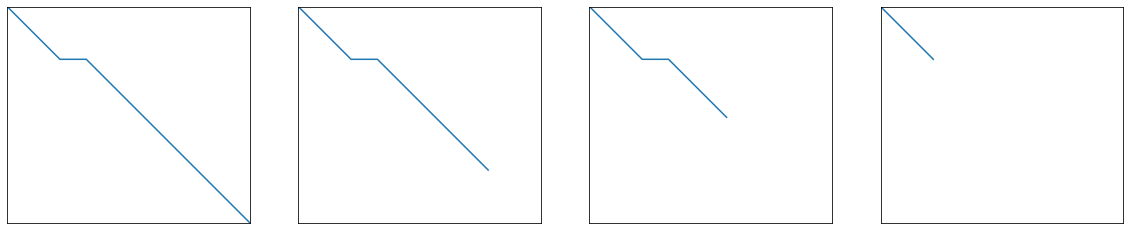

********************
tool = trfermikit-DEL
********************
GCGACCGGAGAAGAATATTGCGCAAGAAACCGAGGAGGTATTGCGC
||||||||||-----|||||||||||||||||||||||||||||||
GCGACCGGAG-----TATTGCGCAAGAAACCGAGGAGGTATTGCGC

GCGACCGGAGAAGAATATTGCGCAAGAAACCGAGGA          
||||||||||-----|||||||||||||||||||||          
GCGACCGGAG-----TATTGCGCAAGAAACCGAGGAGGTATTGCGC

GCGACCGGAG--------AAGAA----------TATTGCGCAAG
||||||||||--------|||||----------||||||||   
GCGACCGGAGTATTGCGCAAGAAACCGAGGAGGTATTGCGC   

GCGACCGGAG--------AAGAAT                 
||||||||||--------|||||                  
GCGACCGGAGTATTGCGCAAGAAACCGAGGAGGTATTGCGC

GCGACC                                   
||||||                                   
GCGACCGGAGTATTGCGCAAGAAACCGAGGAGGTATTGCGC



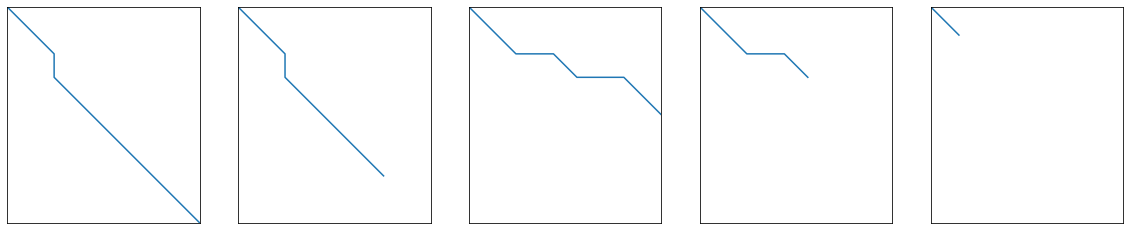

GCGACCGGAG-----TATTGCGCAAGAAACCGAGGAGGTATTGCGC
||||||||||-----|||||||||||||||||||||||||||||||
GCGACCGGAGAAGAATATTGCGCAAGAAACCGAGGAGGTATTGCGC

GCGACCGGAG-----TATTGCGCAAGAAACCGAGGA          
||||||||||-----|||||||||||||||||||||          
GCGACCGGAGAAGAATATTGCGCAAGAAACCGAGGAGGTATTGCGC

GCGACCGGAG-----TATTGCGCAAG                    
||||||||||-----|||||||||||                    
GCGACCGGAGAAGAATATTGCGCAAGAAACCGAGGAGGTATTGCGC

GCGACCGGAGT                                   
||||||||||                                    
GCGACCGGAGAAGAATATTGCGCAAGAAACCGAGGAGGTATTGCGC



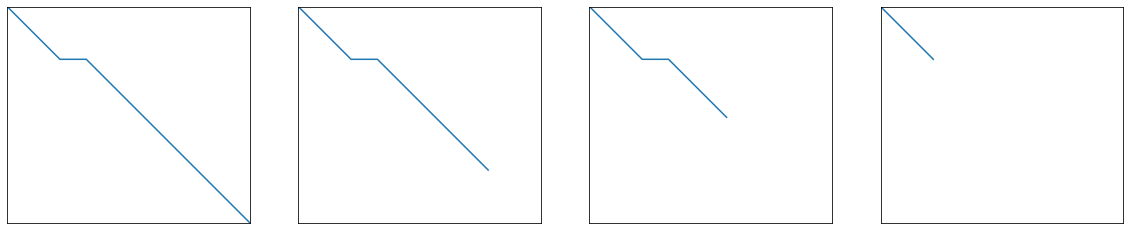

In [13]:
plot_six_tracebacks(
    short_sequence = X + B + A + Y + B,
    long_sequence = X + A + B + A + Y + B)